# BACQUET Maxime et CARON Mathieu

## TP3 : Logistic regression

The purpose of this tutorial is to implement and use the Logistic Regression for binary classification. We will apply this
method to the problem of handwritten characters to learn how to
distinguish two numbers (here 5 and 6).


In [32]:
from pylab import *
import numpy as np
import matplotlib.pyplot as plt

from numpy import linalg as la

## 1. Logistic regression, IRLS algorithm.

### Preliminary question: the algorithm

#### Have a look at the function `regression_logistique.m` and locate the main steps of the algorithm you have been taught (see course).
You can comment the code in the cell below.

In [33]:
def regression_logistique(X,t,Nitermax=20,eps_conv=1e-3):
    '''Entrees :
    X = [ones(N_train,1) x_train];
    t = class_train 
    Nitermax = nombre maximale d'itérations (20 par défaut)
    eps_conv = critère de convergence sur norm(w-w_old)/norm(w) ; 
    eps_conv=1e-3 par défaut
    
    Sorties : 
    w : vecteur des coefficients de régression logistique
   Niter : nombre d'itérations utilisées effectivement
   
   Fonction de régression logistique pour la classification binaire.
   
   Utilisation :
       Nitermax = 50
       eps_conv = 1e-4
       [w,Niter] = regression_logistique(X,t,Nitermax,eps_conv)
    '''
    N_train = X.shape[0]

    # Initialisation : 1 pas de l'algorithme IRLS

    # w initialisé comme vecteur nul de dimension le nombre d'attributs
    w = np.zeros((X.shape[1],))
    w_old = w 
    # initialisation de l'activation ("w.x") à 0, y = sgm(wx) vaut alors 0.5
    y = 1/2*np.ones((N_train,))
    R = np.diag(y*(1-y)) # diag(y_n(1-y_n))
    # initialisation de z (old)
    z = X.dot(w_old)-la.inv(R).dot(y-t)
    # calcul de w pour la première étape avec les valeurs initialisées
    w = la.inv(X.T.dot(R).dot(X)).dot(X.T).dot(R).dot(z)

    # Boucle appliquant l'algorithme de Newton-Raphson

    # on commence à 1 car on a déjà fait la première itération
    Niter = 1
    # Boucle while avec pour condition d'arrêt: 
    # w et w_old sont suffisamment proches
    # OU on atteint un nombre maximum d'itérations
    while ( (la.norm(w-w_old)/la.norm(w)>eps_conv) & (Niter<Nitermax) ):
        # on ajoute une itération de boucle
        Niter = Niter+1
        # on calcule y avec la fonction sigma
        y = 1/(1+np.exp(-X.dot(w)))
        # Mise à jour de R
        R = np.diag(y*(1-y))  
        # on calcule ensuite z et w avec les formules données par la méthode de Newton-Raphson
        w_old = w 
        z = X.dot(w_old)-la.inv(R).dot(y-t) 
        w = la.inv(X.T.dot(R).dot(X)).dot(X.T).dot(R).dot(z)
         
    return w, Niter

Les commentaires ont été ajouté dans la cellule de code au dessus

### Reading & preparing synthetic data

Load the training and test data sets `synth_train.txt`
and `synth_test.txt`. The targets t belong to {1,2} and the features  
x belong to R^2. 

We have 100 training samples and 200 test samples

* the 1st column contains the label of each sample, 
* columns 2 and 3 contain the coordinate of each point.

In [34]:
# Training set
synth_train = np.loadtxt('synth_train.txt') 
class_train = synth_train[:,0]
class_train_1 = np.where(synth_train[:,0]==1)[0]
class_train_2 = np.where(synth_train[:,0]==2)[0]
x_train = synth_train[:,1:]
N_train = np.size(x_train,axis=0)

# Test set
synth_test = np.loadtxt('synth_test.txt')
class_test = synth_test[:,0]
class_test_1 = np.where(synth_test[:,0]==1)[0]
class_test_2 = np.where(synth_test[:,0]==2)[0]
x_test = synth_test[:,1:]
N_test = np.size(x_test,axis=0)

Etant donné que nous sommes dans R^2, un premier réflexe est de visualiser nos données.

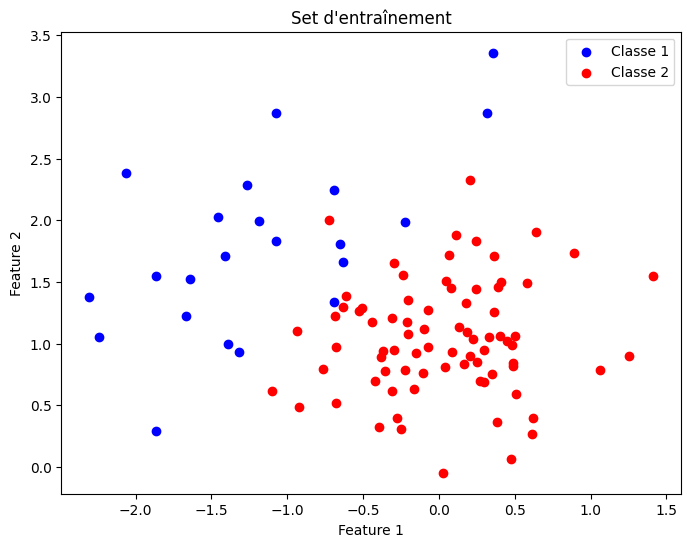

In [35]:
# Affichage du set d'entraînement
plt.figure(figsize=(8, 6))
plt.scatter(x_train[class_train_1, 0], x_train[class_train_1, 1], c='b', label='Classe 1')
plt.scatter(x_train[class_train_2, 0], x_train[class_train_2, 1], c='r', label='Classe 2')
plt.title('Set d\'entraînement')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.savefig("img/premiere-visualisation-set-entrainement.png")
plt.show()

Pour ce qui est du set d'entrainement, on peut apercevoir tous les points des classes 1 et 2 et on peut identifier à l'oeil deux clusters qui sont nos deux classes 1 et 2. 

On peut aussi voir que nous avons plus de points dans le classe 2 que dans le classe 1.

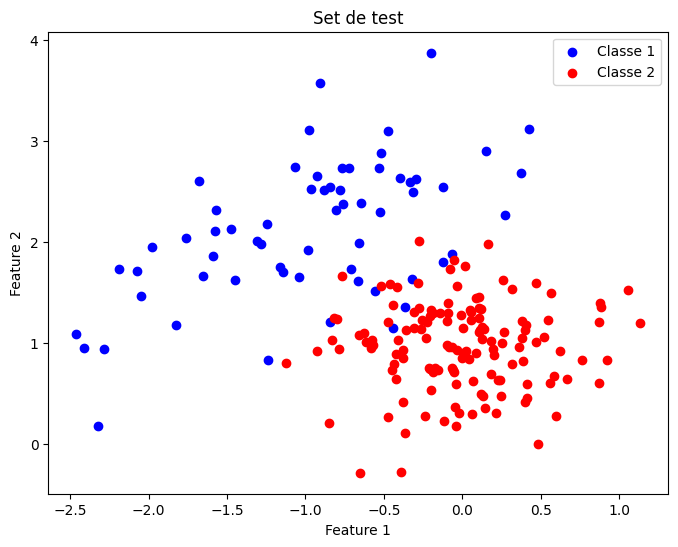

In [36]:
# Affichage du set de test
plt.figure(figsize=(8, 6))
plt.scatter(x_test[class_test_1, 0], x_test[class_test_1, 1], c='b', label='Classe 1')
plt.scatter(x_test[class_test_2, 0], x_test[class_test_2, 1], c='r', label='Classe 2')
plt.title('Set de test')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.savefig("img/premiere-visualisation-set-test.png")
plt.show()

On observe la même chose pour notre set de test. On voit aussi que pour nos deux set on a une répartition légèrement déséquilibrée entre les deux classes (notamment plus de classe 2 que de classe 1 dans notre training set). Nous pouvons donc commencer à faire un preprocessing des données pour réaliser une régression logistique.

### Preparing features for logistic regression (binary classification)
First, we prepare the feature matrix and the target vector associated to 
the training and test sets:


In [37]:
X = np.hstack((np.ones((N_train,1)),x_train))
t = 2-class_train   # 0 if class=2, 1 if class=1

X_test = np.hstack((np.ones((N_test,1)),x_test))
t_test = 2-class_test   # 0 if class=2, 1 if class=1

### Exercise 1 : the logistic function of decision

1. Use the function `regression_logistique.m` to estimate the logistic
regression vector `w`. *Indication : use `Nitermax = 50;
eps_conv=1e-3;`.*
2. Compute the decision function $f(x) = argmax_k P(C_k|x)$ on the test set
to get the classification results. Recall that $y_n=\sigma(w^T x)$ (logistic function)
and that *using vectors* you may directly write $y=\sigma(Xw)$, with the
column of ones in X.
3. Display the results by plotting the points from both the training set
and the test set.
4. Write the equation which defines the decision boundary.
5. Artificially add a few points to the training set far from the decision boundary to check the robustness of logistic regression to outliers. Check the behaviour of LDA for comparison in this case and comment. 


#### Question 1

In [38]:
Nitermax = 50
w, Niter = regression_logistique(X, t, Nitermax) # eps_conv=1e-3 par defaut

print("Estimated logistic regression vector w:")
print(w)
print(f"w was found in {Niter} iterations")

Estimated logistic regression vector w:
[-15.206658    -7.91866363   6.56243114]
w was found in 9 iterations


Le modèle de régression logistique a donc été estimé avec les coefficients suivants :

- $w_0 = -15.206658$
- $w_1 = -7.91866363$
- $w_2 = 6.56243114$

Ces coefficients définissent une frontière de décision linéaire qui sépare les deux classes dans l'espace des caractéristiques. Plus précisément, la frontière de décision est définie par l'équation :

$ -15.206658 - 7.91866363 \cdot x_1 + 6.56243114 \cdot x_2 = 0 $


#### Question 2

In [39]:
def sigma(a): return 1/(1+np.exp(-a)) # sigmoid function

# On définit une classe pour la LogisticRegression afin de compute the decision function
class LogisticRegression():
    
    # On définit nos paramètres
    def __init__(self, train_data, train_target, threshold = 0.5, Nitermax = 50, eps_conv = 1e-3):
        self.train_data = train_data
        self.train_target = train_target
        self.threshold = threshold
        self.Nitermax = Nitermax
        self.eps_conv = eps_conv
        self.coefs, self.Niter = self.__get_coeffs()

    # Méthode pour avoir nos coeffs  
    def __get_coeffs(self):
        return regression_logistique(self.train_data, self.train_target, self.Nitermax, self.eps_conv)
    
    # Méthode de prédiction
    def predict(self, test_data):
        pred = sigma(test_data.dot(self.coefs))
        return np.where(pred >= self.threshold, 1, 0)

In [40]:
# On définit notre object de Logistic regression avec les valeurs de la Q1
logReg = LogisticRegression(X, t)
# On fait la prediction sur notre test set
logReg.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1])

#### Question 3

In [41]:
# Import de librairies utiles pour affichage
import sklearn as skl
import seaborn as sns
from sklearn import metrics

In [42]:
# Definition de la grille pour affichage
x1_bounds=(-2.5, 1.5)
x2_bounds=(-1, 5)
figsize=(20,5)

#### Cas du test set

In [29]:
# Data
test_data = X_test
test_target = t_test

# On fait la prédiction de nos data avec la LogisticRegression
prediction = logReg.predict(test_data)

# Calcul des errors
is_wrong_prediction = np.logical_or(np.logical_and(prediction[:] == 1, test_target[:] == 0), np.logical_and(prediction[:] == 0, test_target[:] == 1))
errors = test_data[is_wrong_prediction, :][:,1:]
error_rate = len(errors) / len(test_data)

Affichage des résultats

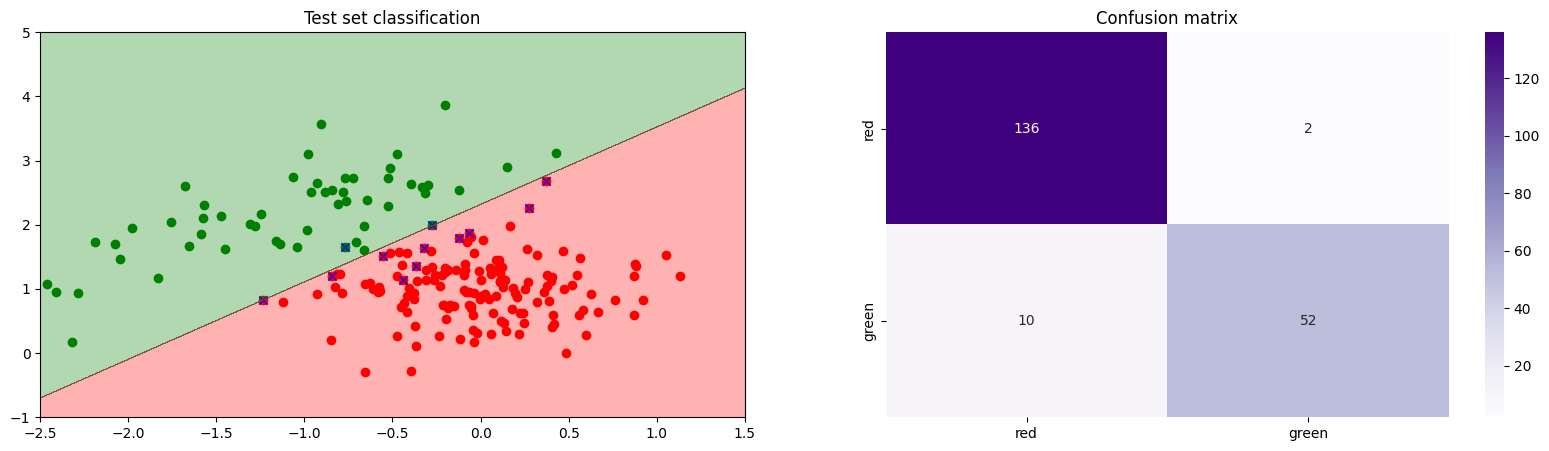

In [30]:
# Resolution
resolution = 1000

# Affichage des resultats pour le test set
plt.figure(figsize=figsize)

# Graphique pour les prédictions et frontière de décision
plt.subplot(121)

# On affiche les prédictions du test set avec des marqueurs bleus pour les prédictions fausses
x_predicted_0 = test_data[prediction[:] == 0, :][:,1:]
x_predicted_1 = test_data[prediction[:] == 1, :][:,1:]

plt.scatter(x_predicted_0[:,0], x_predicted_0[:,1], c='r')
plt.scatter(x_predicted_1[:,0], x_predicted_1[:,1], c='g')
plt.scatter(errors[:,0], errors[:,1], c='b', marker = 'x')
plt.title("Test set classification")

# On affiche des régions de décisions et de la frontière de décision
x1 = np.linspace(x1_bounds[0], x1_bounds[1], resolution) 
x2 = np.linspace(x2_bounds[0], x2_bounds[1], resolution) 
X1, X2 = meshgrid(x1,x2)

X = np.stack((np.ones(resolution**2), np.ravel(X1), np.ravel(X2))).T
Z = f_predict(X).reshape(X1.shape)

plt.contourf(X1, X2, Z, colors=['r', 'g', 'b', "y", 'purple'], alpha = 0.3)

# On peut afficher la confusion matrix aussi
confusion_matrix = skl.metrics.confusion_matrix(test_target, prediction)
plt.subplot(122)
plt.title("Confusion matrix")
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap=plt.cm.Purples, xticklabels=['red', 'green'], yticklabels=['red', 'green'])   

plt.savefig("img/classification-result-logistic-regression-test-set.png")

Notre classification est plutôt bonne, on peut le voir sur le graphique de gauche avec notre frontière de décision. Nous avons tout de même quelques erreurs et plus précisément avec la confusion matrix nous pouvons voir que nous avons 10 points de la classe verte (classe 1) qui ont été mal classifiés en classe rouge (classe 2) et 2 points de la classe rouge (classe 2) qui ont été mal classifiés en classe verte (classe 1)

#### Cas du train set

In [43]:
# Data
test_data = X
test_target = t

# On fait la prédiction de nos data avec la LogisticRegression
prediction = logReg.predict(test_data)

# Calcul des errors
is_wrong_prediction = np.logical_or(np.logical_and(prediction[:] == 1, test_target[:] == 0), np.logical_and(prediction[:] == 0, test_target[:] == 1))
errors = test_data[is_wrong_prediction, :][:,1:]
error_rate = len(errors) / len(test_data)

Affichage des résultats

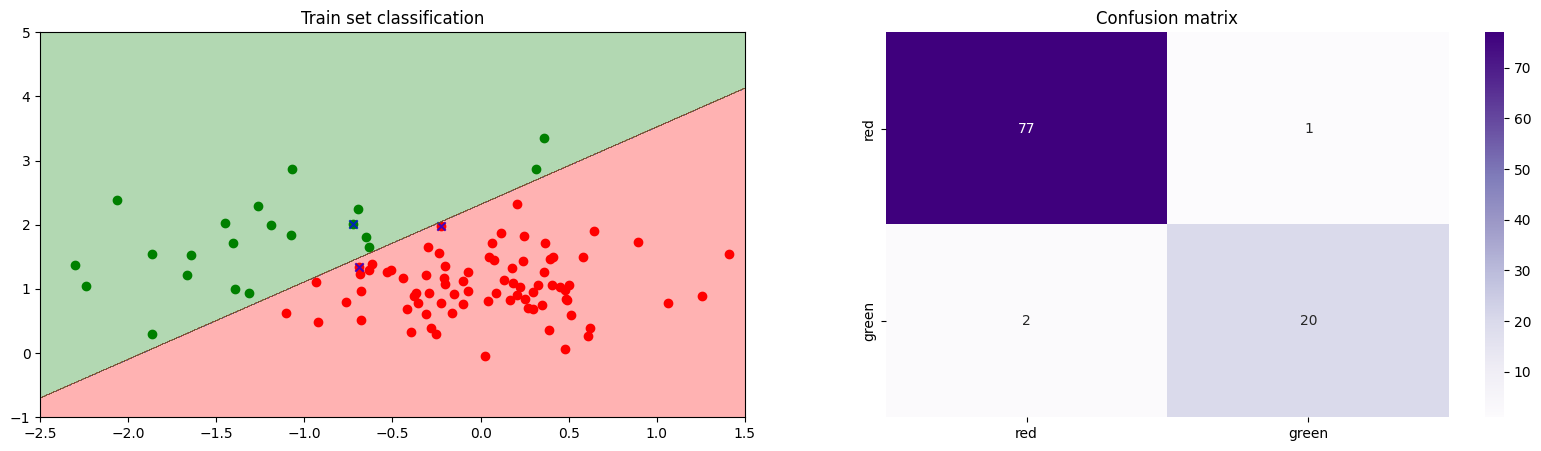

In [44]:
# Resolution
resolution = 1000

# Affichage des resultats pour le test set
plt.figure(figsize=figsize)

# Graphique pour les prédictions et frontière de décision
plt.subplot(121)

# On affiche les prédictions du test set avec des marqueurs bleus pour les prédictions fausses
x_predicted_0 = test_data[prediction[:] == 0, :][:,1:]
x_predicted_1 = test_data[prediction[:] == 1, :][:,1:]

plt.scatter(x_predicted_0[:,0], x_predicted_0[:,1], c='r')
plt.scatter(x_predicted_1[:,0], x_predicted_1[:,1], c='g')
plt.scatter(errors[:,0], errors[:,1], c='b', marker = 'x')
plt.title("Train set classification")

# On affiche des régions de décisions et de la frontière de décision
x1 = np.linspace(x1_bounds[0], x1_bounds[1], resolution) 
x2 = np.linspace(x2_bounds[0], x2_bounds[1], resolution) 
X1, X2 = meshgrid(x1,x2)

X = np.stack((np.ones(resolution**2), np.ravel(X1), np.ravel(X2))).T
Z = f_predict(X).reshape(X1.shape)

plt.contourf(X1, X2, Z, colors=['r', 'g', 'b', "y", 'purple'], alpha = 0.3)

# On peut afficher la confusion matrix aussi
confusion_matrix = skl.metrics.confusion_matrix(test_target, prediction)
plt.subplot(122)
plt.title("Confusion matrix")
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap=plt.cm.Purples, xticklabels=['red', 'green'], yticklabels=['red', 'green'])   

plt.savefig("img/classification-result-logistic-regression-train-set.png")

In [ ]:
# Results for the training set
classification_train = BinaryPointsClassification(X, t, logReg.predict)
classification_train.display_prediction(x1_bounds, x2_bounds, resolution = 1000, figsize = figsize, title = f"Train set classification (error rate: {classification_train.error_rate*100}%)")

In [21]:
class BinaryPointsClassification():
    """Utility class to help with displaying prediction results and error rates.
    """

    def __init__(self, test_data, test_target, f_predict):
    
        self.test_data = test_data
        self.test_target = test_target
        self.f_predict = f_predict
        
        self.prediction = self.f_predict(test_data)
        self.errors, self.error_rate = self.__errors()
        
        self.confusion_matrix = skl.metrics.confusion_matrix(self.test_target, self.prediction)
        
        
    def __errors(self):
        """Returns the points that were classified wrongly and the error rate.
        """
        
        is_wrong_prediction = np.logical_or(np.logical_and(self.prediction[:] == 1, self.test_target[:] == 0), np.logical_and(self.prediction[:] == 0, self.test_target[:] == 1))
        errors = self.test_data[is_wrong_prediction, :][:,1:]
        error_rate = len(errors) / len(self.test_data)
        
        return errors, error_rate

    def predicted_points_figure(self, title=""):
        """Given a set of points and binary predictions (0-1), returns a graph showing the classification, crossing out the mistakes.
        """
        
        x_predicted_0 = self.test_data[self.prediction[:] == 0, :][:,1:]
        x_predicted_1 = self.test_data[self.prediction[:] == 1, :][:,1:]

        plt.scatter(x_predicted_0[:,0], x_predicted_0[:,1], c='r')
        plt.scatter(x_predicted_1[:,0], x_predicted_1[:,1], c='g')
        plt.scatter(self.errors[:,0], self.errors[:,1], c='b', marker = 'x')
        plt.title(title + "\n(mistakes are crossed out in blue)")
        
        
    def decision_regions_figure(self, x1_bounds, x2_bounds, resolution=1000):
        """Displays the decision regions for a given resolution (number of points along each axis).
        """

        x1 = np.linspace(x1_bounds[0], x1_bounds[1], resolution) 
        x2 = np.linspace(x2_bounds[0], x2_bounds[1], resolution) 
        X1, X2 = meshgrid(x1,x2)
        
        X = np.stack((np.ones(resolution**2), np.ravel(X1), np.ravel(X2))).T
        Z = self.f_predict(X).reshape(X1.shape)

        plt.contourf(X1, X2, Z, colors=['r', 'g', 'b', "y", 'purple'], alpha = 0.3) # extra colors are necessary otherwise everything is green and the boundary is red         
        
        
    def confusion_matrix_heatmap(self):
        """Displays the heatmap corresponding to the confusion matrix."""
        sns.heatmap(self.confusion_matrix, annot=True, fmt='d', cmap=plt.cm.Purples, xticklabels=['red', 'green'], yticklabels=['red', 'green'])      
         
        
    def display_prediction(self, x1_bounds, x2_bounds, resolution = 1000, figsize=(20,5) , title = "Classification"):
        """Convenient all-in-one display function. Displays the decision regions, the classified points (with mistakes) and the confusion matrix heatmap.
        """
        
        plt.figure(figsize=figsize)

        plt.subplot(121)
        self.predicted_points_figure(title)
        self.decision_regions_figure(x1_bounds, x2_bounds, resolution)

        plt.subplot(122)
        plt.title("Confusion matrix\nThe X axis corresponds to predicted labels")
        self.confusion_matrix_heatmap()

ValueError: shapes (10000,2) and (3,) not aligned: 2 (dim 1) != 3 (dim 0)

#### Question 4

#### Question 5

You can draw the decision boundary $w^Tx = 0$ by using: 


In [ ]:
# First compute w... then: 
x1 = np.linspace(-2.5,1.5,10) 
x2 = (-w[0]-w[1]*x1)/w[2]
plt.plot(x1,x2,'k--')
# ...

## 2. Application: handwritten digits recognition 5 & 6
We load 2 matrices which contain each a sequence of examples of 16x16 images 
of handwritten digits which are 5 and 6 here. Each line of the matrix
contains 256 pixel values coding for the gray level of a 16x16 image.

In [6]:
train_5 = np.loadtxt('train_5.txt',delimiter=',')   # 556 samples
train_6 = np.loadtxt('train_6.txt',delimiter=',')   # 664 samples

### Examples of images


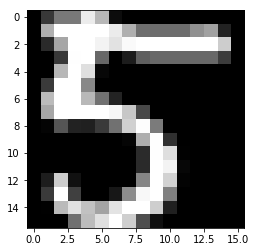

In [7]:
# Digit 5
n=9;
I = np.reshape(train_5[n,:],(16,16))

plt.imshow(I,cmap='gray')
plt.show()

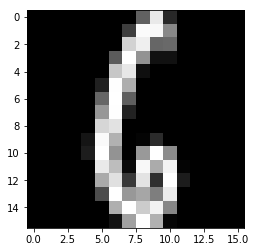

In [8]:
# Digit 6
n=5;
I = reshape(train_6[n,:],(16,16))

plt.imshow(I,cmap='gray')
plt.show()

### Separating the training and test sets

We keep in the training set the 145 first images of 5s and the 200 first
images of 6s:


In [ ]:
x_train_brut = np.vstack((train_5[:145,:], train_6[:200,:]))
N_train = np.size(x_train_brut,axis=0)
class_train = np.ones((345,1))   # label 1 for digit 6
class_train[:145] = 0       # label 0 for digit 5

x_test_brut = np.vstack((train_5[145:,:], train_6[200:,:]))
N_test = np.size(train_5,axis=0)+np.size(train_6,axis=0)-N_train

## Exercise 2: logistic regression to classify 5 & 6

1. Note that pixel values are between -1 and 1 by using the functions
 `min(I(:))` and `max(I(:))`.
2. Identify the indices of the most significant pixels, which are defined 
as having a standard deviation greater than 0.5 here. We denote by `lis_sig`
the list of positions of these significant pixels in the image vector.
_Indication : the function `std` gives the standard deviation (columnwise
in matrices) and you should find 173 pixel positions.
3. Show a binary image to locate these pixels.
_Indication : `Isig = zeros(16); Isig(list_sig)=1; Isig=Isig';`._
4. Define the training set `x_train` from `x_train_brut` from the significant pixels only.
5. Do the same with `x_test_brut` to extract `x_test`.
6. Use `regression_logistique.m` to estimate the logistic regression vector
`w` from the training set `x_train`. 
Choose `Nitermax = 13; eps_conv = 1e-3;`
7. Compute the decision function and the labels of the test set `x_test`. 
_Indication : do not forget the column of ones !_
8. Estimate the classification error rate by using :
`erreur = sum(abs(class-class_test))/N_test;`.
9. Locate some misclassified examples and visualize the corresponding image.
Comment on your results and observations.


In [ ]:
# Exercise 2

## 3. Logistic regression using `scikit-learn`

1. **Go to** http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html for a presentation of the logistic regression model in `scikit-learn`.

2. **Apply** it to the present data set.

3. **Comment** on the use of logistic regression.

*Indication : you may have a look at* 

a) Theory : http://openclassroom.stanford.edu/MainFolder/DocumentPage.php?course=MachineLearning&doc=exercises/ex5/ex5.html

b) Video :  https://kr.coursera.org/lecture/machine-learning/regularized-logistic-regression-cAxpF 

c) Example : http://scikit-learn.org/stable/auto_examples/exercises/plot_digits_classification_exercise.html#sphx-glr-auto-examples-exercises-plot-digits-classification-exercise-py

*for a short presentation of regularized logistic regression.*

In [ ]:
# Include your code here
from sklearn.linear_model import LogisticRegression
# ...


Commentaires :